# 3.4 Transformadores

## Data Loading e Pré-processamento

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

from transformers import BertTokenizer, DistilBertTokenizer, RobertaTokenizer, BertModel, DistilBertModel, RobertaModel, BertForSequenceClassification, DistilBertForSequenceClassification, RobertaForSequenceClassification
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW

In [2]:
# Ler os arquivos CSV
df_train = pd.read_csv("imdb_reviews_train.csv", quoting=0, on_bad_lines='skip')
df_test = pd.read_csv("imdb_reviews_test.csv", quoting=0, on_bad_lines='skip')
df_train.count()
df_test.count()

print("Número de linhas no conjunto de treino:", df_train.shape[0])
print("Número de linhas no conjunto de teste:", df_test.shape[0])

print(f"O conjunto treino tem {sum(df_train['label'] == 'pos')} reviews positivas")
print(f"O conjunto treino tem {sum(df_train['label'] == 'neg')} reviews negativas")

print(f"O conjunto teste tem {sum(df_test['label'] == 'pos')} reviews positivas")
print(f"O conjunto teste tem {sum(df_test['label'] == 'neg')} reviews negativas")

Número de linhas no conjunto de treino: 21754
Número de linhas no conjunto de teste: 21996
O conjunto treino tem 10776 reviews positivas
O conjunto treino tem 10978 reviews negativas
O conjunto teste tem 10946 reviews positivas
O conjunto teste tem 11050 reviews negativas


In [3]:
# Remover linhas duplicadas com base na coluna 'text' e mantendo a primeira ocorrência
df_train = df_train.drop_duplicates(subset=['text'], keep='first')
df_test = df_test.drop_duplicates(subset=['text'], keep='first')
df_train.count()
df_test.count()

print("Número de linhas no conjunto de treino após remoção de linhas duplicadas:",  df_train.shape[0])
print("Número de linhas no conjunto de teste após remoção de linhas duplicadas:", df_test.shape[0])

print(f"O conjunto treino tem {sum(df_train['label'] == 'pos')} reviews positivas")
print(f"O conjunto treino tem {sum(df_train['label'] == 'neg')} reviews negativas")

print(f"O conjunto teste tem {sum(df_test['label'] == 'pos')} reviews positivas")
print(f"O conjunto teste tem {sum(df_test['label'] == 'neg')} reviews negativas")

Número de linhas no conjunto de treino após remoção de linhas duplicadas: 21662
Número de linhas no conjunto de teste após remoção de linhas duplicadas: 21814
O conjunto treino tem 10748 reviews positivas
O conjunto treino tem 10914 reviews negativas
O conjunto teste tem 10888 reviews positivas
O conjunto teste tem 10926 reviews negativas


In [4]:
# Exemplo
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_train['text'][:10]

df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_test['text'][:10]

<ipython-input-4-1ba7f0e1ba44>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text'] = df_train['text'].apply(lambda x: x.lower())


,text
0,logan lerman & dean collins iii of jack & bobb...
1,i have seen this film on a sunday evening and ...
2,two great stars and a legendary director creat...
3,i'm originally from brazil... the sad thing ab...
4,"""witchery"" is a decent little euro trash horro..."
5,the best so bad it's good movie ever made. rud...
6,"okay, i'll say it. this movie made me laugh so..."
7,this movie almost has everything. the action i...
8,this movie is ageless and would probably appea...
9,"great book, great movie, great soundtrack. fra..."


## BERT

### Tokenizer

In [5]:
# Tokenizador pré-treinado BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts, tokenizer, max_length=384):
    encoding = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    # Retorna os input_ids e attention_mask
    return encoding.input_ids, encoding.attention_mask

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# Alpicar Tokenizador
train_input_ids, train_attention_masks = tokenize_data(df_train['text'], tokenizer)
test_input_ids, test_attention_masks = tokenize_data(df_test['text'], tokenizer)

In [7]:
# Converter os rótulos em tensores
train_labels = torch.tensor(df_train['label'].apply(lambda x: 1 if x == 'pos' else 0).values)
test_labels = torch.tensor(df_test['label'].apply(lambda x: 1 if x == 'pos' else 0).values)

train_dataset_full = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_size = int(0.8 * len(train_dataset_full))  # 80% dos dados para treino
val_size = len(train_dataset_full) - train_size   # O restante 20% para validação
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Criar DataLoader
batch_size = 16  # Define o tamanho do lote para treino e validação
# Para o treino, utilizamos RandomSampler
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
# Para validação, utilizamos SequentialSampler
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
# Para teste, também utilizamos SequentialSampler
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

### Pre-trained BERT for Binary Classification (Without Fine-tuning)

In [8]:
# Carregar o modelo BERT pré-treinado
bert = BertModel.from_pretrained('bert-base-uncased')

# Congelar os pesos do modelo BERT
for param in bert.parameters():
    param.requires_grad = False

# Definir uma classe
class BERTFrozenClassifier(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, 1)

    # Forward pass function
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embedding = outputs.last_hidden_state[:, 0, :]

        logits = self.classifier(cls_embedding)
        return logits

model = BERTFrozenClassifier(bert)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
# Verifica se há uma GPU disponível, caso contrário usa a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loop de treinamento
epochs = 3
for epoch in range(epochs):
    print(f"Época {epoch + 1}/{epochs}")

    model.train()
    total_loss_train = 0
    correct_train = 0
    total_train = 0

    # Loop sobre os batches no DataLoader
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask).squeeze(-1)
        loss = criterion(logits, labels.float())
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        preds = torch.sigmoid(logits) > 0.5
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Cálculo de métricas
    avg_train_loss = total_loss_train / len(train_dataloader)
    train_acc = correct_train / total_train
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # ----------------- Fase de Validação -----------------

    model.eval()
    total_loss_val = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Desativa o cálculo de gradientes
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            logits = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(logits, labels.float())
            total_loss_val += loss.item()

            preds = torch.sigmoid(logits) > 0.5
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Cálculo de métricas
    avg_val_loss = total_loss_val / len(val_dataloader)
    val_acc = correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Época 1/3
Training Loss: 0.5937, Training Accuracy: 0.7568
Validation Loss: 0.5048, Validation Accuracy: 0.8251
Época 2/3
Training Loss: 0.4904, Training Accuracy: 0.8134
Validation Loss: 0.4443, Validation Accuracy: 0.8241
Época 3/3
Training Loss: 0.4454, Training Accuracy: 0.8235
Validation Loss: 0.4002, Validation Accuracy: 0.8518


Test Accuracy: 0.8378
Test Precision: 0.8294
Test Recall: 0.8498
Test F1 Score: 0.8395


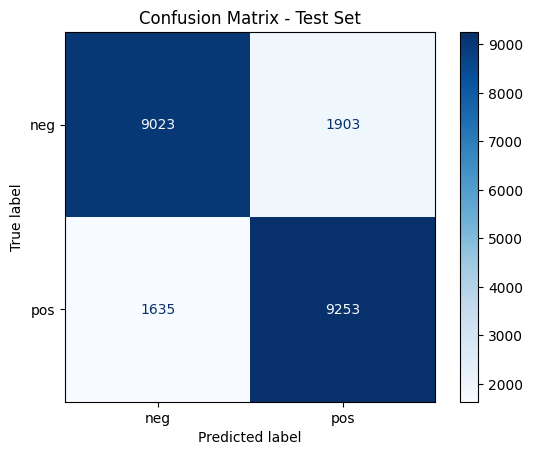

In [11]:
model.eval()
num_samples = len(test_dataloader.dataset)
all_preds = np.zeros(num_samples)
all_labels = np.zeros(num_samples)

# Desativa o cálculo de gradientes
with torch.no_grad():
    index = 0
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        logits = model(input_ids, attention_mask).squeeze(-1)
        preds = torch.sigmoid(logits) > 0.5

        batch_size = labels.size(0)
        all_preds[index:index+batch_size] = preds.cpu().numpy()
        all_labels[index:index+batch_size] = labels.cpu().numpy()

        index += batch_size

# Cálculo de métricas
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Matriz de Confusão
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

### Pre-trained BERT for Binary Classification (With Fine-tuning)

In [12]:
# Carregar o modelo BERT pré-treinado com uma camada de classificação (para fine-tuning)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Verifica se há uma GPU disponível, caso contrário usa a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loop de treinamento
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    model.train()
    total_loss_train = 0
    correct_train = 0
    total_train = 0

    # Loop sobre os batches no DataLoader
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  # Forward pass
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Cálculo de métricas
    avg_train_loss = total_loss_train / len(train_dataloader)
    train_acc = correct_train / total_train
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # ----------------- Fase de Validação -----------------

    model.eval()
    total_loss_val = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Desativa o cálculo de gradientes
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_loss_val += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Cálculo de métricas
    avg_val_loss = total_loss_val / len(val_dataloader)
    val_acc = correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/3
Training Loss: 0.2391, Training Accuracy: 0.9048
Validation Loss: 0.1793, Validation Accuracy: 0.9280
Epoch 2/3
Training Loss: 0.1199, Training Accuracy: 0.9590
Validation Loss: 0.1830, Validation Accuracy: 0.9398
Epoch 3/3
Training Loss: 0.0612, Training Accuracy: 0.9806
Validation Loss: 0.1901, Validation Accuracy: 0.9372


Test Accuracy: 0.9394
Test Precision: 0.9377
Test Recall: 0.9411
Test F1 Score: 0.9394


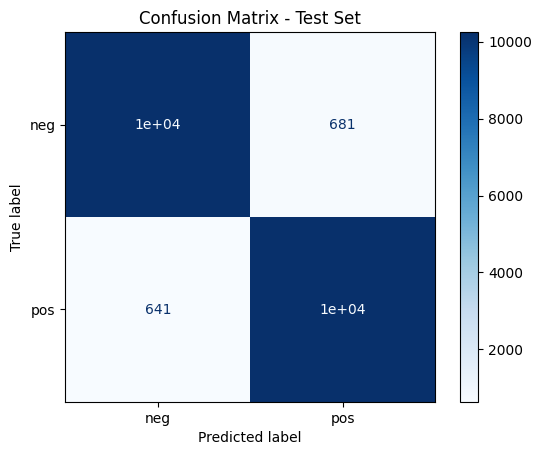

In [14]:
model.eval()
num_samples = len(test_dataloader.dataset)
all_preds = np.zeros(num_samples)
all_labels = np.zeros(num_samples)
index = 0

# Desativa o cálculo de gradientes
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        batch_size = labels.size(0)

        all_preds[index:index + batch_size] = preds.cpu().numpy()
        all_labels[index:index + batch_size] = labels.cpu().numpy()
        index += batch_size


# Cálculo de métricas
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Matriz de Confusão
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

## DistilBERT

### Tokenizer

In [15]:
# Tokenizador pré-treinado DistilBERT
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data_distilbert(texts, tokenizer, max_length=384):
    encoding = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    # Retorna os input_ids e attention_mask
    return encoding.input_ids, encoding.attention_mask

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [16]:
train_input_ids_1, train_attention_masks_1 = tokenize_data_distilbert(df_train['text'], tokenizer_distilbert)
test_input_ids_1, test_attention_masks_1 = tokenize_data_distilbert(df_test['text'], tokenizer_distilbert)


In [17]:
# Converter os rótulos em tensores
train_labels_1 = torch.tensor(df_train['label'].apply(lambda x: 1 if x == 'pos' else 0).values)
test_labels_1 = torch.tensor(df_test['label'].apply(lambda x: 1 if x == 'pos' else 0).values)

train_dataset_full_1 = TensorDataset(train_input_ids_1, train_attention_masks_1, train_labels_1)
test_dataset_1 = TensorDataset(test_input_ids_1, test_attention_masks_1, test_labels_1)

train_size_1 = int(0.8 * len(train_dataset_full_1))
val_size_1 = len(train_dataset_full_1) - train_size_1
train_dataset_1, val_dataset_1 = random_split(train_dataset_full_1, [train_size_1, val_size_1])

# Criar DataLoader
batch_size_1 = 16
train_dataloader_1 = DataLoader(train_dataset_1, sampler=RandomSampler(train_dataset_1), batch_size=batch_size_1)
val_dataloader_1 = DataLoader(val_dataset_1, sampler=SequentialSampler(val_dataset_1), batch_size=batch_size_1)
test_dataloader_1 = DataLoader(test_dataset_1, sampler=SequentialSampler(test_dataset_1), batch_size=batch_size_1)

### Pre-trained DistilBERT for Binary Classification (Without Fine-tuning)

In [18]:
# Carregar o modelo DistilBERT pré-treinado
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Congelar os pesos do modelo DistilBERT
for param in distilbert.parameters():
    param.requires_grad = False

# Definir uma classe
class DistilBERTFrozenClassifier(nn.Module):
    def __init__(self, distilbert):
        super().__init__()
        self.distilbert = distilbert

        self.classifier = nn.Linear(distilbert.config.hidden_size, 1)

    # Forward pass function
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embedding = outputs.last_hidden_state[:, 0, :]

        logits = self.classifier(cls_embedding)
        return logits

model = DistilBERTFrozenClassifier(distilbert)

# loss function
criterion = nn.BCEWithLogitsLoss()

# optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loop de treinamento
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    model.train()
    total_loss_train = 0
    correct_train = 0
    total_train = 0

    # Loop sobre os batches no DataLoader
    for batch in train_dataloader_1:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask).squeeze(-1)
        loss = criterion(logits, labels.float())
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        preds = torch.sigmoid(logits) > 0.5
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Cálculo de métricas
    avg_train_loss = total_loss_train / len(train_dataloader)
    train_acc = correct_train / total_train
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # ----------------- Fase de Validação -----------------

    model.eval()
    total_loss_val = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Desativa o cálculo de gradientes
        for batch in val_dataloader_1:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            logits = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(logits, labels.float())
            total_loss_val += loss.item()

            preds = torch.sigmoid(logits) > 0.5
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Cálculo de métricas
    avg_val_loss = total_loss_val / len(val_dataloader)
    val_acc = correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/3
Training Loss: 0.6253, Training Accuracy: 0.7471
Validation Loss: 0.5648, Validation Accuracy: 0.8198
Epoch 2/3
Training Loss: 0.5376, Training Accuracy: 0.8114
Validation Loss: 0.4978, Validation Accuracy: 0.8258
Epoch 3/3
Training Loss: 0.4868, Training Accuracy: 0.8221
Validation Loss: 0.4558, Validation Accuracy: 0.8368


Test Accuracy: 0.8309
Test Precision: 0.8321
Test Recall: 0.8283
Test F1 Score: 0.8302


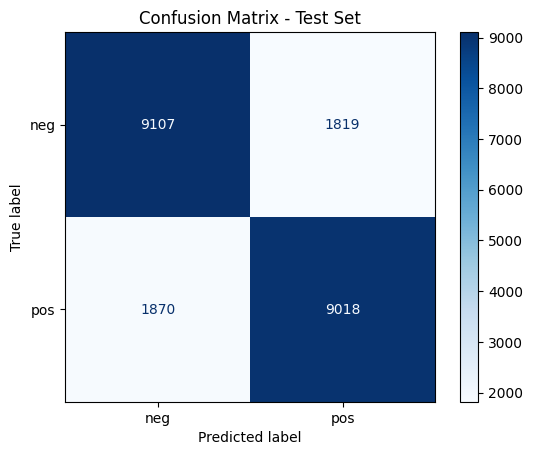

In [20]:
model.eval()
num_samples = len(test_dataloader.dataset)
all_preds = np.zeros(num_samples)
all_labels = np.zeros(num_samples)

# Desativa o cálculo de gradientes
with torch.no_grad():
    index = 0
    for batch in test_dataloader_1:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        logits = model(input_ids, attention_mask).squeeze(-1)
        preds = torch.sigmoid(logits) > 0.5

        batch_size = labels.size(0)
        all_preds[index:index+batch_size] = preds.cpu().numpy()
        all_labels[index:index+batch_size] = labels.cpu().numpy()

        index += batch_size

# Cálculo de métricas
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Matriz de confusão
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

### Pre-trained DistilBERT for Binary Classification (With Fine-tuning)

In [21]:
# Carregar o modelo DistilBERT pré-treinado
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Verifica se há uma GPU disponível, caso contrário usa a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# loss function
criterion = nn.CrossEntropyLoss()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loop de treinamento
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    model.train()
    total_loss_train = 0
    correct_train = 0
    total_train = 0

    # Loop sobre os batches no DataLoader
    for batch in train_dataloader_1:

        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Calculo de métricas
    avg_train_loss = total_loss_train / len(train_dataloader)
    train_acc = correct_train / total_train
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # ----------- Fase de Validação -----------

    model.eval()
    total_loss_val = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Desativa o cálculo de gradientes
        for batch in val_dataloader_1:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_loss_val += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Calculo de métricas
    avg_val_loss = total_loss_val / len(val_dataloader)
    val_acc = correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/3
Training Loss: 0.2636, Training Accuracy: 0.8904
Validation Loss: 0.2064, Validation Accuracy: 0.9234
Epoch 2/3
Training Loss: 0.1428, Training Accuracy: 0.9503
Validation Loss: 0.1809, Validation Accuracy: 0.9298
Epoch 3/3
Training Loss: 0.0754, Training Accuracy: 0.9758
Validation Loss: 0.2128, Validation Accuracy: 0.9229


Test Accuracy: 0.9271
Test Precision: 0.9136
Test Recall: 0.9431
Test F1 Score: 0.9281


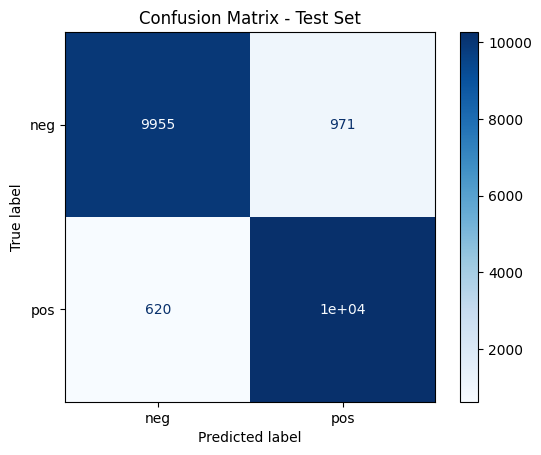

In [23]:
model.eval()
num_samples = len(test_dataloader.dataset)
all_preds = np.zeros(num_samples)
all_labels = np.zeros(num_samples)
index = 0

# Desativa o cálculo de gradientes
with torch.no_grad():
    for batch in test_dataloader_1:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        batch_size = labels.size(0)

        all_preds[index:index + batch_size] = preds.cpu().numpy()
        all_labels[index:index + batch_size] = labels.cpu().numpy()
        index += batch_size


# Calculo de métricas
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Matriz de confusao
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

## RoBERTa

### Tokenizer

In [24]:
# # Tokenizador pré-treinado RoBERTa tokenizer
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_data_roberta(texts, tokenizer, max_length=384):
    encoding = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    # Retorna os input_ids e attention_mask
    return encoding.input_ids, encoding.attention_mask

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [25]:
train_input_ids_2, train_attention_masks_2 = tokenize_data_roberta(df_train['text'], tokenizer_roberta)
test_input_ids_2, test_attention_masks_2 = tokenize_data_roberta(df_test['text'], tokenizer_roberta)


In [26]:
# Converter os rótulos em tensores
train_labels_2 = torch.tensor(df_train['label'].apply(lambda x: 1 if x == 'pos' else 0).values)
test_labels_2 = torch.tensor(df_test['label'].apply(lambda x: 1 if x == 'pos' else 0).values)

train_dataset_full_2 = TensorDataset(train_input_ids_2, train_attention_masks_2, train_labels_2)
test_dataset_2 = TensorDataset(test_input_ids_2, test_attention_masks_2, test_labels_2)

train_size_2 = int(0.8 * len(train_dataset_full_2))
val_size_2 = len(train_dataset_full_2) - train_size_2
train_dataset_2, val_dataset_2 = random_split(train_dataset_full_2, [train_size_2, val_size_2])

# Criar DataLoader
batch_size_2 = 16
train_dataloader_2 = DataLoader(train_dataset_2, sampler=RandomSampler(train_dataset_2), batch_size=batch_size_2)
val_dataloader_2 = DataLoader(val_dataset_2, sampler=SequentialSampler(val_dataset_2), batch_size=batch_size_2)
test_dataloader_2 = DataLoader(test_dataset_2, sampler=SequentialSampler(test_dataset_2), batch_size=batch_size_2)

### Pre-trained RoBERTa for Binary Classification (Without Fine-tuning)

In [27]:
# Carregar o modelo RoBERTa pré-treinado
roberta = RobertaModel.from_pretrained('roberta-base')

# Congelar os pesos do modelo RoBERTa
for param in roberta.parameters():
    param.requires_grad = False

# Definir uma classe
class RoBERTaFrozenClassifier(nn.Module):
    def __init__(self, roberta):
        super().__init__()
        self.roberta = roberta

        self.classifier = nn.Linear(roberta.config.hidden_size, 1)

    # Forward pass function
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
            cls_embedding = outputs.last_hidden_state[:, 0, :]

        logits = self.classifier(cls_embedding)
        return logits

model = RoBERTaFrozenClassifier(roberta)

# loss function
criterion = nn.BCEWithLogitsLoss()

# optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loop de treinamento
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    model.train()
    total_loss_train = 0
    correct_train = 0
    total_train = 0

    # Loop sobre os batches no DataLoader
    for batch in train_dataloader_2:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask).squeeze(-1)
        loss = criterion(logits, labels.float())
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        preds = torch.sigmoid(logits) > 0.5
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Calcula metricas
    avg_train_loss = total_loss_train / len(train_dataloader)
    train_acc = correct_train / total_train
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # ----------------- Fase de Validacao -----------------

    model.eval()
    total_loss_val = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Desativa o cálculo de gradientes
        for batch in val_dataloader_2:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            logits = model(input_ids, attention_mask).squeeze(-1)
            loss = criterion(logits, labels.float())
            total_loss_val += loss.item()
            preds = torch.sigmoid(logits) > 0.5
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Calculo de métricas
    avg_val_loss = total_loss_val / len(val_dataloader)
    val_acc = correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/3
Training Loss: 0.6883, Training Accuracy: 0.6024
Validation Loss: 0.6803, Validation Accuracy: 0.8064
Epoch 2/3
Training Loss: 0.6733, Training Accuracy: 0.7311
Validation Loss: 0.6685, Validation Accuracy: 0.7955
Epoch 3/3
Training Loss: 0.6602, Training Accuracy: 0.7762
Validation Loss: 0.6562, Validation Accuracy: 0.8290


Test Accuracy: 0.8279
Test Precision: 0.8109
Test Recall: 0.8544
Test F1 Score: 0.8321


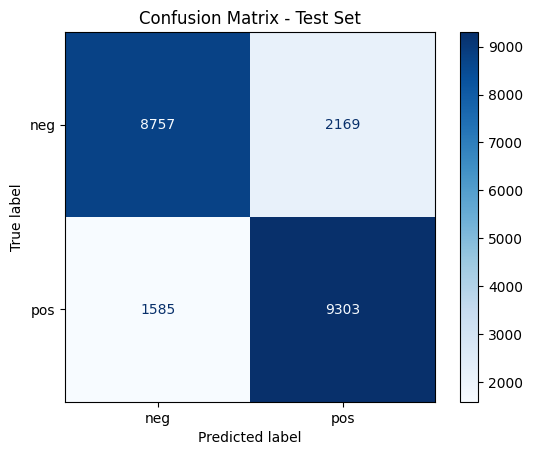

In [29]:
model.eval()
num_samples = len(test_dataloader.dataset)
all_preds = np.zeros(num_samples)
all_labels = np.zeros(num_samples)

 # Desativa o cálculo de gradientes
with torch.no_grad():
    index = 0
    for batch in test_dataloader_2:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        logits = model(input_ids, attention_mask).squeeze(-1)
        preds = torch.sigmoid(logits) > 0.5

        batch_size = labels.size(0)
        all_preds[index:index+batch_size] = preds.cpu().numpy()
        all_labels[index:index+batch_size] = labels.cpu().numpy()

        index += batch_size

# Calculo de metricas
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Matriz de confusao
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

### Pre-trained RoBERTa for Binary Classification (With Fine-tuning)

In [30]:
# # Carregar o modelo RoBERTa pré-treinado
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Verifica se há uma GPU disponível, caso contrário usa a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# loss function
criterion = nn.CrossEntropyLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loop de treinamento
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    model.train()
    total_loss_train = 0
    correct_train = 0
    total_train = 0

    # Loop sobre os batches no DataLoader
    for batch in train_dataloader_2:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Calculo de metricas
    avg_train_loss = total_loss_train / len(train_dataloader_2)
    train_acc = correct_train / total_train
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # ----------------- Fase de validacao -----------------

    model.eval()
    total_loss_val = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Desativa o cálculo de gradientes
        for batch in val_dataloader_2:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)
            loss = criterion(logits, labels)
            total_loss_val += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Calculo de metricas
    avg_val_loss = total_loss_val / len(val_dataloader_2)
    val_acc = correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/3
Training Loss: 0.2209, Training Accuracy: 0.9112
Validation Loss: 0.1735, Validation Accuracy: 0.9379
Epoch 2/3
Training Loss: 0.1295, Training Accuracy: 0.9555
Validation Loss: 0.1816, Validation Accuracy: 0.9391
Epoch 3/3
Training Loss: 0.0848, Training Accuracy: 0.9726
Validation Loss: 0.1625, Validation Accuracy: 0.9402


Test Accuracy: 0.9476
Test Precision: 0.9345
Test Recall: 0.9624
Test F1 Score: 0.9482


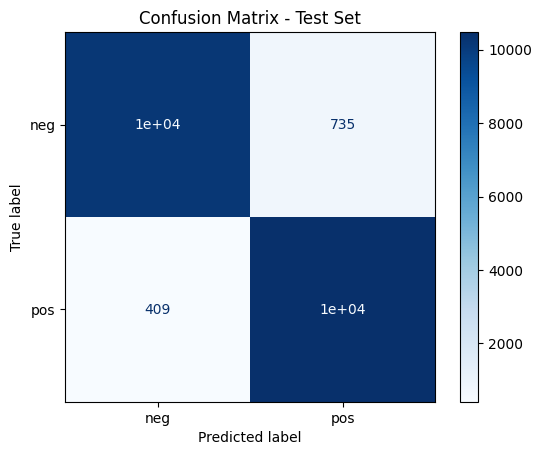

In [32]:
model.eval()
num_samples = len(test_dataloader_2.dataset)
all_preds = np.zeros(num_samples)
all_labels = np.zeros(num_samples)

 # Desativa o cálculo de gradientes
with torch.no_grad():
    index = 0
    for batch in test_dataloader_2:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)
        preds = torch.argmax(logits, dim=1)

        batch_size = labels.size(0)
        all_preds[index:index + batch_size] = preds.cpu().numpy()
        all_labels[index:index + batch_size] = labels.cpu().numpy()

        index += batch_size

# Calculo de metricas
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Matriz de confusao
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()